In [2]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from tqdm.notebook import tqdm
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import glob
import os
import sys
import pickle

from tqdm.notebook import tqdm
from datetime import datetime

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import FunctionTransformer, RobustScaler, MinMaxScaler, StandardScaler, LabelBinarizer
from sklearn.preprocessing import normalize, robust_scale, minmax_scale

from sklearn.preprocessing import OneHotEncoder,KBinsDiscretizer, LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GroupKFold, KFold, train_test_split, LeaveOneOut

from sklearn.metrics import make_scorer, confusion_matrix, roc_auc_score, roc_curve, plot_confusion_matrix, f1_score, recall_score, accuracy_score

from sklearn.multiclass import OneVsRestClassifier

from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer

import pymc3 as pm

from Preprocessing_Methods import *

import torch

from scipy.signal import savgol_filter

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [5]:
total = pd.read_hdf('./Original.hdf', key='Data').round(6)

patient_ids = total.reset_index()['Patient_nu '].unique()

total['1yeardeath'] = ((total.reset_index()['survival (months)']<12) & (total.reset_index()['Alive']==False)).values
total = truncate(total.set_index('1yeardeath', append=True), start=1000, end=1800)

<AxesSubplot:>

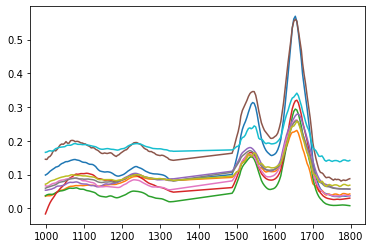

In [7]:
total.sample(10).T.plot(legend=False)

# 1D conv net define

In [8]:
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms

In [9]:
# Truncate and eliminate paraffin contribution

total_p = pd.DataFrame(FunctionTransformer(normalize, kw_args = {"axis": 1}).fit_transform(total), index=total.index, columns=total.columns)
total_p = total_p.sample(frac=1)

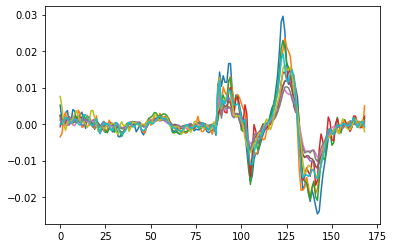

In [10]:
plt.plot(savgol_filter(total_p.sample(10),7,5, deriv=1, axis=1).T);

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [12]:
from conv import *

In [13]:
in_data = np.stack([total_p, savgol_filter(total_p.values, 3,1, deriv=1), savgol_filter(total_p.values, 3,1, deriv=2)],axis=2)

In [14]:
def channel_stack(input):

    return np.stack([input, savgol_filter(input, 3,1, deriv=1), savgol_filter(input, 3,1, deriv=2)],axis=2)

In [15]:
trn = total_p.iloc[:100000,:]
tst = total_p.iloc[100000:200000,:]

trn_x = channel_stack(trn.values)
tst_x = channel_stack(tst.values)

trn_y = OneHotEncoder(sparse=False).fit_transform(trn.reset_index()['1yeardeath'].astype(np.int).values[:,None])

tst_y = OneHotEncoder(sparse=False).fit_transform(tst.reset_index()['1yeardeath'].astype(np.int).values[:,None])

In [34]:
train_dataset = FTIR_Dataset_C(trn_x, trn_y)
test_dataset = FTIR_Dataset_C(tst_x, tst_y)

loss_fn = nn.BCELoss()

train_dataloader = DataLoader(train_dataset, batch_size=64)
test_dataset = DataLoader(test_dataset, batch_size=64)

model = SpecConvNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


In [36]:
train_dataset[0][0].shape

torch.Size([169, 3])

In [33]:
epochs = 3

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataset, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------


RuntimeError: Given groups=1, weight of size [8, 3, 5], expected input[64, 169, 3] to have 3 channels, but got 169 channels instead